# Telecom Churn 

## Business Problem Overview:

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

* For many incumbent operators, retaining high profitable customers is the number one business goal.

* To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, I will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Introduction & Background:

There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully. Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.

## What is Chrun? 

There are various ways to define churn, such as:

  1. Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

  2. Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

In this project, you will use the usage-based definition to define churn.

## High - Value Churn:

In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

### Understanding the business objective and the data:

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour during Churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import plotly.graph_objs as go
import plotly.offline as py
import pandas_profiling as pp
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

## Importing the Dataset

In [2]:
telecom_data = pd.read_csv("telecom_churn_data.csv")

In [3]:
telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
telecom_data.shape

(99999, 226)

### Data Dictionary

In [5]:
telecom_data_dict = pd.read_excel("Data+Dictionary-+Telecom+Churn+Case+Study.xlsx")
telecom_data_dict

,Acronyms,Descriptions
0,MOBILE_NUMBER,Customer phone number
1,CIRCLE_ID,Telecom circle area to which the customer belo...
2,LOC,Local calls - within same telecom circle
3,STD,STD calls - outside the calling circle
4,IC,Incoming calls
5,OG,Outgoing calls
6,T2T,"Operator T to T, i.e. within same operator (mo..."
7,T2M,Operator T to other operator mobile
8,T2O,Operator T to other operator fixed line
9,T2F,Operator T to fixed lines of T


## Summary of Data

In [6]:
telecom_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [7]:
telecom_data.describe().T

,count,mean,std,min,25%,50%,75%,max
mobile_number,99999.0,7.001207e+09,695669.386290,7.000000e+09,7.000606e+09,7.001205e+09,7.001812e+09,7.002411e+09
circle_id,99999.0,1.090000e+02,0.000000,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02
loc_og_t2o_mou,98981.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
std_og_t2o_mou,98981.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
loc_ic_t2o_mou,98981.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
aon,99999.0,1.219855e+03,954.733842,1.800000e+02,4.670000e+02,8.630000e+02,1.807500e+03,4.337000e+03
aug_vbc_3g,99999.0,6.817025e+01,267.580450,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.291622e+04
jul_vbc_3g,99999.0,6.683906e+01,271.201856,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.165600e+03
jun_vbc_3g,99999.0,6.002120e+01,253.938223,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.116621e+04


## Unique Value

In [8]:
unique_1_col=[]
for i in telecom_data.columns:
    if telecom_data[i].nunique() == 1:
        unique_1_col.append(i)
    else:
        pass

telecom_data.drop(unique_1_col, axis=1, inplace = True)
print("\n The following Columns are dropped from the dataset as their unique value is 1. (i.e.)It has no variance in the model\n",
      unique_1_col)


 The following Columns are dropped from the dataset as their unique value is 1. (i.e.)It has no variance in the model
 ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


In [9]:
telecom_data.shape

(99999, 210)

## Total Missing Values

In [10]:
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending = False)

max_rech_data_6     74.85
fb_user_6           74.85
count_rech_3g_6     74.85
count_rech_2g_6     74.85
night_pck_user_6    74.85
                    ...  
max_rech_amt_9       0.00
max_rech_amt_8       0.00
max_rech_amt_7       0.00
max_rech_amt_6       0.00
sep_vbc_3g           0.00
Length: 210, dtype: float64

* As we can see that the columns with datetime values represented as object, they can be converted into datetime format

In [11]:
# selecting all the columns with datetime format
date_col = telecom_data.select_dtypes(include = ['object'])
print("\nThese are the columns available with datetime format represented as object\n",date_col.columns)

# Converting the selected columns to datetime format
for i in date_col.columns:
    telecom_data[i] = pd.to_datetime(telecom_data[i])

# Current dimension of the dataset
telecom_data.shape


These are the columns available with datetime format represented as object
 Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')


(99999, 210)

In [12]:
telecom_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 210 columns):
 #    Column                    Dtype         
---   ------                    -----         
 0    mobile_number             int64         
 1    arpu_6                    float64       
 2    arpu_7                    float64       
 3    arpu_8                    float64       
 4    arpu_9                    float64       
 5    onnet_mou_6               float64       
 6    onnet_mou_7               float64       
 7    onnet_mou_8               float64       
 8    onnet_mou_9               float64       
 9    offnet_mou_6              float64       
 10   offnet_mou_7              float64       
 11   offnet_mou_8              float64       
 12   offnet_mou_9              float64       
 13   roam_ic_mou_6             float64       
 14   roam_ic_mou_7             float64       
 15   roam_ic_mou_8             float64       
 16   roam_ic_mou_9             float64     

## Handling missing values

In [13]:
telecom_data[['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6']].head(10)

,date_of_last_rech_data_6,total_rech_data_6,max_rech_data_6
0,2014-06-21,1.0,252.0
1,NaT,NaN,NaN
2,NaT,NaN,NaN
3,NaT,NaN,NaN
4,2014-06-04,1.0,56.0
5,NaT,NaN,NaN
6,NaT,NaN,NaN
7,NaT,NaN,NaN
8,NaT,NaN,NaN
9,NaT,NaN,NaN


* Let us conside the column date_of_last_rech_data indicating the date of the last recharge made in any given month for mobile internet. Here it can deduced if the total_rech_data and the max_rech_data also has missing values, the missing values in all the columns mentioned can be considered as meaningful missing.

* Hence imputing 0 as their values.

* Meaningfull missing in this case represents the the customer has not done any recharge for mobile interenet.

### Handling the missing values for the attributes - total_rech_data_*,  max_rech_data_*  and for month 6,7,8 and 9

In [14]:
# Code for conditional imputation
start_time = time.time()
for i in range(len(telecom_data)):
  # Handling 'total_rech_data', 'max_rech_data' and for month 6
    if pd.isnull((telecom_data['total_rech_data_6'][i]) and (telecom_data['max_rech_data_6'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_6'][i]):
            telecom_data['total_rech_data_6'][i] = 0
            telecom_data['max_rech_data_6'][i] = 0

  # Handling 'total_rech_data', 'max_rech_data' and for month 7
    if pd.isnull((telecom_data['total_rech_data_7'][i]) and (telecom_data['max_rech_data_7'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_7'][i]):
            telecom_data['total_rech_data_7'][i] = 0
            telecom_data['max_rech_data_7'][i] = 0

  # Handling 'total_rech_data', 'max_rech_data' and for month 8
    if pd.isnull((telecom_data['total_rech_data_8'][i]) and (telecom_data['max_rech_data_8'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_8'][i]):
            telecom_data['total_rech_data_8'][i] = 0
            telecom_data['max_rech_data_8'][i] = 0

  # Handling 'total_rech_data', 'max_rech_data' and for month 9
    if pd.isnull((telecom_data['total_rech_data_9'][i]) and (telecom_data['max_rech_data_9'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_9'][i]):
            telecom_data['total_rech_data_9'][i] = 0
            telecom_data['max_rech_data_9'][i] = 0

end_time = time.time()
print("\nExecution Time = ", round(end_time-start_time,2),"seconds")
print("The columns \n'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9'\n'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9' are imputed with 0 based on the condition explained above")


Execution Time =  279.39 seconds
The columns 
'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9'
'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9' are imputed with 0 based on the condition explained above


### Handling the missing values for the attributes - count_rech_2g_*, count_rech_3g_*  for month 6,7,8 and 9

In [15]:
telecom_data[['count_rech_2g_6', 'count_rech_3g_6', 'total_rech_data_6']].head(10)

,count_rech_2g_6,count_rech_3g_6,total_rech_data_6
0,0.0,1.0,1.0
1,NaN,NaN,0.0
2,NaN,NaN,0.0
3,NaN,NaN,0.0
4,1.0,0.0,1.0
5,NaN,NaN,0.0
6,NaN,NaN,0.0
7,NaN,NaN,0.0
8,NaN,NaN,0.0
9,NaN,NaN,0.0


From the above tablular the column values of total_rech_data for each month from 6 to 9 respectively is the sum of the columns values of count_rech_2g for each month from 6 to 9 respectively and count_rech_3g for each month from 6 to 9 respectively, which derives to a multicollinearity issue. 

In order to reduce the multicollinearity, we can drop the columns count_rech_2g for each month from 6 to 9 respectively and count_rech_3g for each month from 6 to 9 respectively.

In [16]:
# Dropping the columns 'count_rech_2g_*' & 'count_rech_3g_*' for the months 6,7,8 and 9 
telecom_data.drop(['count_rech_2g_6','count_rech_3g_6',
                   'count_rech_2g_7','count_rech_3g_7',
                   'count_rech_2g_8','count_rech_3g_8',
                   'count_rech_2g_9','count_rech_3g_9'], axis = 1, inplace = True)

print("The 'count_rech_2g_6', 'count_rech_3g_6', 'count_rech_2g_7', 'count_rech_3g_7', 'count_rech_2g_8', 'count_rech_3g_8',' count_rech_2g_9', 'count_rech_3g_9' columns are dropped as they can be explained from the 'total_rech_data'column")

The 'count_rech_2g_6', 'count_rech_3g_6', 'count_rech_2g_7', 'count_rech_3g_7', 'count_rech_2g_8', 'count_rech_3g_8',' count_rech_2g_9', 'count_rech_3g_9' columns are dropped as they can be explained from the 'total_rech_data'column


In [17]:
telecom_data.shape

(99999, 202)

### Handling the missing values for the attributes - arpu_3g_*, arpu_2g_*  for month 6,7,8 and 9

In [18]:
telecom_data[['arpu_3g_6', 'arpu_2g_6', 'av_rech_amt_data_6']].head(10)

,arpu_3g_6,arpu_2g_6,av_rech_amt_data_6
0,212.17,212.17,252.0
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,0.00,0.00,56.0
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


## Correlation 

In [19]:
# Checking the correlation between the above mentioned columns in tabular for months 6,7,8 and 9
print("Correlation table for month 6\n\n", telecom_data[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].corr())
print("\nCorrelation table for month 7\n\n", telecom_data[['arpu_3g_7','arpu_2g_7','av_rech_amt_data_7']].corr())
print("\nCorrelation table for month 8\n\n", telecom_data[['arpu_3g_8','arpu_2g_8','av_rech_amt_data_8']].corr())
print("\nCorrelation table for month 9\n\n", telecom_data[['arpu_3g_9','arpu_2g_9','av_rech_amt_data_9']].corr())

Correlation table for month 6

                     arpu_3g_6  arpu_2g_6  av_rech_amt_data_6
arpu_3g_6            1.000000   0.932232            0.809695
arpu_2g_6            0.932232   1.000000            0.834065
av_rech_amt_data_6   0.809695   0.834065            1.000000

Correlation table for month 7

                     arpu_3g_7  arpu_2g_7  av_rech_amt_data_7
arpu_3g_7            1.000000   0.930366            0.796131
arpu_2g_7            0.930366   1.000000            0.815933
av_rech_amt_data_7   0.796131   0.815933            1.000000

Correlation table for month 8

                     arpu_3g_8  arpu_2g_8  av_rech_amt_data_8
arpu_3g_8            1.000000   0.924925            0.787165
arpu_2g_8            0.924925   1.000000            0.805482
av_rech_amt_data_8   0.787165   0.805482            1.000000

Correlation table for month 9

                     arpu_3g_9  arpu_2g_9  av_rech_amt_data_9
arpu_3g_9            1.000000   0.852253            0.722932
arpu_2g_9      

* From the above correlation table between attributes arpu_2g_* and arpu_3g_* for each month from 6 to 9 respectively is highly correlated to the attribute av_rech_amt_data_* for each month from 6 to 9 respectively.



* Considering the high correlation between them, it is safer to drop the attributes arpu_2g_* and arpu_3g_*.

In [20]:
# Dropping the columns 'arpu_3g_*'&'arpu_2g_*' in month 6,7,8 and 9 datafrom the dataset
telecom_data.drop(['arpu_3g_6','arpu_2g_6',
                  'arpu_3g_7','arpu_2g_7',
                  'arpu_3g_8','arpu_2g_8',
                  'arpu_3g_9','arpu_2g_9'], axis = 1, inplace = True)
print("\nThe columns'arpu_3g_6', 'arpu_2g_6', 'arpu_3g_7', 'arpu_2g_7', 'arpu_3g_8', 'arpu_2g_8', 'arpu_3g_9', 'arpu_2g_9' are dropped from the dataset due to high corellation between their respective arpu_* variable in the dataset\n")


The columns'arpu_3g_6', 'arpu_2g_6', 'arpu_3g_7', 'arpu_2g_7', 'arpu_3g_8', 'arpu_2g_8', 'arpu_3g_9', 'arpu_2g_9' are dropped from the dataset due to high corellation between their respective arpu_* variable in the dataset



In [21]:
telecom_data.shape

(99999, 194)

### Handling the other attributes with higher missing value percentage


   The column fb_user_* and night_pck_user_* for each month from 6 to 9 respectively has a missing values above 50% and does not seem to add any information to understand the data. Hence we can drop these columns for further analysis.

In [22]:
telecom_data.drop(['fb_user_6','fb_user_7','fb_user_8','fb_user_9',
                  'night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9'],
                   axis = 1, inplace = True)
print("\nThe columns 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9' are dropped from the dataset as it has no meaning to the data snd has high missing values above 50%\n")


The columns 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9' are dropped from the dataset as it has no meaning to the data snd has high missing values above 50%



In [23]:
telecom_data.shape

(99999, 186)

### Handling the missing values for the attributes - av_rech_amt_data_*  for month 6,7,8 and 9

In [24]:
telecom_data[['av_rech_amt_data_7', 'max_rech_data_7', 'total_rech_data_7']].head(10)

,av_rech_amt_data_7,max_rech_data_7,total_rech_data_7
0,252.0,252.0,1.0
1,154.0,154.0,1.0
2,NaN,0.0,0.0
3,NaN,0.0,0.0
4,NaN,0.0,0.0
5,NaN,0.0,0.0
6,NaN,0.0,0.0
7,NaN,0.0,0.0
8,177.0,154.0,2.0
9,154.0,154.0,1.0


From the above tabular it is deduced that the missing values for the column av_rech_amt_data_* for each month from 6 to 9 can be replaced as 0 if the total_rech_data_* for each month from 6 to 9 respectively is 0. i.e. if the total recharge done is 0 then the average recharge amount shall also be 0.

In [25]:
# Code for conditional imputation
start_time = time.time()
for i in range(len(telecom_data)):
  # Handling `av_rech_amt_data`  for month 6
    if (pd.isnull(telecom_data['av_rech_amt_data_6'][i]) and (telecom_data['total_rech_data_6'][i] == 0)):
        telecom_data['av_rech_amt_data_6'][i] = 0

  # Handling `av_rech_amt_data`  for month 7
    if (pd.isnull(telecom_data['av_rech_amt_data_7'][i]) and (telecom_data['total_rech_data_7'][i] == 0)):
        telecom_data['av_rech_amt_data_7'][i] = 0

  # Handling `av_rech_amt_data`  for month 8
    if (pd.isnull(telecom_data['av_rech_amt_data_8'][i]) and (telecom_data['total_rech_data_8'][i] == 0)):
        telecom_data['av_rech_amt_data_8'][i] = 0

  # Handling `av_rech_amt_data`  for month 9
    if (pd.isnull(telecom_data['av_rech_amt_data_9'][i]) and (telecom_data['total_rech_data_9'][i] == 0)):
        telecom_data['av_rech_amt_data_9'][i] = 0


end_time=time.time()
print("\nExecution Time = ", round(end_time-start_time,2),"seconds")
print("\nThe columns 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8' and 'av_rech_amt_data_9' are imputed with 0 based on the condition explained above\n")


Execution Time =  116.01 seconds

The columns 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8' and 'av_rech_amt_data_9' are imputed with 0 based on the condition explained above



In [26]:
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending = False)

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_9    74.08
date_of_last_rech_data_8    73.66
og_others_9                  7.75
                            ...  
max_rech_amt_7               0.00
max_rech_amt_6               0.00
total_rech_amt_9             0.00
total_rech_amt_8             0.00
sep_vbc_3g                   0.00
Length: 186, dtype: float64

In [27]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 186 entries, mobile_number to sep_vbc_3g
dtypes: datetime64[ns](8), float64(144), int64(34)
memory usage: 141.9 MB


* From the above results, we can conclude, the date_of_last_rech_data_* corresponding to months 6,7,8 and 9 are of no value after the conditional imputation of of columns total_rech_data_*, max_rech_data_*are completes.


* Also the missing value percentage is high for these columns and can be dropped from the dataset.

In [28]:
# Dropping the columns related to datetime dtype from the dataset
telecom_data.drop(["date_of_last_rech_data_6", "date_of_last_rech_data_7",
                   "date_of_last_rech_data_8", "date_of_last_rech_data_9"], axis = 1, inplace = True)
print("\nThe columns 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9' are dropped as it has no significance to the data\n")


The columns 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9' are dropped as it has no significance to the data



### As we can no more utilise the datetime column, we can drop the date_of_last_rech_data_* column corresponding to months 6,7,8 and 9 respectively.

In [29]:
# Dropping the columns related to datetime dtype from the dataset
telecom_data.drop(["date_of_last_rech_6", "date_of_last_rech_7",
                   "date_of_last_rech_8", "date_of_last_rech_9"], axis = 1, inplace = True)
print("\nThe columns 'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9' are dropped as it has no significance to the data\n")


The columns 'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9' are dropped as it has no significance to the data



In [30]:
telecom_data.shape

(99999, 178)

* Since the columns used to determine the High Value Customer is clear of null values, 
* we can filter the overall data and then handle the remaining missing values for each column

## Filtering the High Value Customer from Good Phase

In [31]:
# Filtering the data 
 # We are filtering the data in accordance to total revenue generated per customer.

 # first we need the total amount recharge amount done for data alone, we have average rechage amount done. 

 # Calculating the total recharge amount done for data alone in months 6,7,8 and 9
telecom_data['total_rech_amt_data_6'] = telecom_data['av_rech_amt_data_6'] * telecom_data['total_rech_data_6']
telecom_data['total_rech_amt_data_7'] = telecom_data['av_rech_amt_data_7'] * telecom_data['total_rech_data_7']

# Calculating the overall recharge amount for the months 6,7,8 and 9
telecom_data['overall_rech_amt_6'] = telecom_data['total_rech_amt_data_6'] + telecom_data['total_rech_amt_6']
telecom_data['overall_rech_amt_7'] = telecom_data['total_rech_amt_data_7'] + telecom_data['total_rech_amt_7']

# Calculating the average recharge done by customer in months June and July(i.e. 6th and 7th month)
telecom_data['avg_rech_amt_6_7'] = (telecom_data['overall_rech_amt_6'] + telecom_data['overall_rech_amt_7'])/2

# Finding the value of 70th percentage in the overall revenues defining the high value customer creteria for the company
cut_off = telecom_data['avg_rech_amt_6_7'].quantile(0.70)
print("\nThe 70th quantile value to determine the High Value Customer is: ",cut_off,"\n")

# Filtering the data to the top 30% considered as High Value Customer
telecom_data = telecom_data[telecom_data['avg_rech_amt_6_7'] >= cut_off]


The 70th quantile value to determine the High Value Customer is:  478.0 



In [32]:
telecom_data.shape

(30001, 183)

* The total number of customers is now limited to ~30k who lies under the High Value customer criteria basen upon which the model is built.

In [33]:
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending = False)

loc_ic_t2f_mou_9    6.34
spl_og_mou_9        6.34
loc_og_t2m_mou_9    6.34
loc_og_t2f_mou_9    6.34
loc_ic_t2t_mou_9    6.34
                    ... 
max_rech_amt_8      0.00
max_rech_amt_7      0.00
max_rech_amt_6      0.00
total_rech_amt_9    0.00
avg_rech_amt_6_7    0.00
Length: 183, dtype: float64

*** The remaining attributes with missing value can be imputed using the advanced imputation technique like KNNImputer.***

In [34]:
# Numerical columns available
num_col = telecom_data.select_dtypes(include = ['int64','float64']).columns.tolist()

In [35]:
# Importing the libraries for Scaling and Imputation
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Calling the Scaling function
scalar = MinMaxScaler()

# Scaling and transforming the data for the columns that are numerical
telecom_data[num_col] = scalar.fit_transform(telecom_data[num_col])

# Calling the KNN Imputer function
knn = KNNImputer(n_neighbors = 3)

# Imputing the NaN values using KNN Imputer
start_time = time.time()

telecom_data_knn = pd.DataFrame(knn.fit_transform(telecom_data[num_col]))
telecom_data_knn.columns = telecom_data[num_col].columns

end_time = time.time()
print("\nExecution Time = ", round(end_time-start_time,2),"seconds\n")


Execution Time =  94.47 seconds



In [36]:
# check for any null values after imputation for numerical columns
telecom_data_knn.isnull().sum().sum()

0

* The KNN Imputer has replaced all the null values in the numerical column usingK-means algorithm sucessfully

In [37]:
# Since we sclaed the numerical columns for the purpose of handling the null values, 
    #we can restore the sclaed alues to its original form.

# Converting the scaled data back to the original data
telecom_data[num_col] = scalar.inverse_transform(telecom_data_knn)

# Checking the top 10 data
telecom_data.head(10)

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,overall_rech_amt_6,overall_rech_amt_7,avg_rech_amt_6_7
0,7.000843e+09,197.385,214.816,213.803,21.100,53.27,24.613333,0.00,33.590000,84.23,...,968.0,30.40,0.00,101.20,3.58,252.0,252.0,614.0,504.0,559.0
7,7.000702e+09,1069.180,1349.850,3171.480,500.000,57.84,54.680000,52.29,65.276667,453.43,...,802.0,57.74,19.38,18.74,0.00,0.0,0.0,1580.0,790.0,1185.0
8,7.001525e+09,378.721,492.223,137.362,166.787,413.69,351.030000,35.08,33.460000,94.66,...,315.0,21.03,910.65,122.16,0.00,0.0,354.0,437.0,955.0,696.0
21,7.002124e+09,514.453,597.753,637.760,578.596,102.41,132.110000,85.14,161.630000,757.93,...,720.0,0.00,0.00,0.00,0.00,0.0,0.0,600.0,680.0,640.0
23,7.000887e+09,74.350,193.897,366.966,811.480,48.96,50.660000,33.58,15.740000,85.41,...,604.0,40.45,51.86,0.00,0.00,0.0,712.0,0.0,1166.0,583.0
33,7.000150e+09,977.020,2362.833,409.230,799.356,0.00,0.000000,0.00,0.000000,0.00,...,1328.0,358.10,2706.83,1714.67,0.00,5285.0,20424.0,6343.0,23230.0,14786.5
38,7.000815e+09,363.987,486.558,393.909,391.709,248.99,619.960000,666.38,494.790000,88.86,...,1155.0,0.00,0.00,0.00,0.00,0.0,0.0,420.0,636.0,528.0
41,7.000721e+09,482.832,425.764,229.769,143.596,86.39,118.880000,80.44,40.060000,232.36,...,2010.0,0.00,0.00,0.00,0.00,0.0,0.0,496.0,510.0,503.0
48,7.000294e+09,1873.271,575.927,179.218,1189.744,2061.69,881.430000,156.91,1589.230000,1087.76,...,1265.0,0.00,0.00,0.00,0.00,0.0,0.0,2317.0,580.0,1448.5
53,7.002189e+09,978.077,1141.296,706.020,1076.247,135.14,119.590000,102.69,99.830000,479.31,...,697.0,0.00,0.00,0.00,0.00,344.0,575.0,1503.0,1947.0,1725.0


In [38]:
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending = False)

mobile_number       0.0
isd_ic_mou_8        0.0
ic_others_6         0.0
ic_others_7         0.0
ic_others_8         0.0
                   ... 
spl_og_mou_8        0.0
spl_og_mou_9        0.0
og_others_6         0.0
og_others_7         0.0
avg_rech_amt_6_7    0.0
Length: 183, dtype: float64

In [39]:
# Reconfirming for missing values if any
telecom_data.isnull().sum().sum()

0

## Defining Churn variable

* As explained above in the introduction, we are deriving based on usage based for this model.

* For that, we need to find the derive churn variable using total_ic_mou_9,total_og_mou_9,vol_2g_mb_9 and vol_3g_mb_9 attributes

In [40]:
# Selecting the columns to define churn variable (i.e. TARGET Variable)
churn_col = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
telecom_data[churn_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_ic_mou_9  30001 non-null  float64
 1   total_og_mou_9  30001 non-null  float64
 2   vol_2g_mb_9     30001 non-null  float64
 3   vol_3g_mb_9     30001 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


In [41]:
# Initializing the churn variable.
telecom_data['churn'] = 0

# Imputing the churn values based on the condition
telecom_data['churn'] = np.where(telecom_data[churn_col].sum(axis = 1) == 0, 1, 0)

In [42]:
telecom_data.head(10)

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,...,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,overall_rech_amt_6,overall_rech_amt_7,avg_rech_amt_6_7,churn
0,7.000843e+09,197.385,214.816,213.803,21.100,53.27,24.613333,0.00,33.590000,84.23,...,30.40,0.00,101.20,3.58,252.0,252.0,614.0,504.0,559.0,1
7,7.000702e+09,1069.180,1349.850,3171.480,500.000,57.84,54.680000,52.29,65.276667,453.43,...,57.74,19.38,18.74,0.00,0.0,0.0,1580.0,790.0,1185.0,1
8,7.001525e+09,378.721,492.223,137.362,166.787,413.69,351.030000,35.08,33.460000,94.66,...,21.03,910.65,122.16,0.00,0.0,354.0,437.0,955.0,696.0,0
21,7.002124e+09,514.453,597.753,637.760,578.596,102.41,132.110000,85.14,161.630000,757.93,...,0.00,0.00,0.00,0.00,0.0,0.0,600.0,680.0,640.0,0
23,7.000887e+09,74.350,193.897,366.966,811.480,48.96,50.660000,33.58,15.740000,85.41,...,40.45,51.86,0.00,0.00,0.0,712.0,0.0,1166.0,583.0,0
33,7.000150e+09,977.020,2362.833,409.230,799.356,0.00,0.000000,0.00,0.000000,0.00,...,358.10,2706.83,1714.67,0.00,5285.0,20424.0,6343.0,23230.0,14786.5,0
38,7.000815e+09,363.987,486.558,393.909,391.709,248.99,619.960000,666.38,494.790000,88.86,...,0.00,0.00,0.00,0.00,0.0,0.0,420.0,636.0,528.0,0
41,7.000721e+09,482.832,425.764,229.769,143.596,86.39,118.880000,80.44,40.060000,232.36,...,0.00,0.00,0.00,0.00,0.0,0.0,496.0,510.0,503.0,0
48,7.000294e+09,1873.271,575.927,179.218,1189.744,2061.69,881.430000,156.91,1589.230000,1087.76,...,0.00,0.00,0.00,0.00,0.0,0.0,2317.0,580.0,1448.5,0
53,7.002189e+09,978.077,1141.296,706.020,1076.247,135.14,119.590000,102.69,99.830000,479.31,...,0.00,0.00,0.00,0.00,344.0,575.0,1503.0,1947.0,1725.0,0


0    91.863605
1     8.136395
Name: churn, dtype: float64


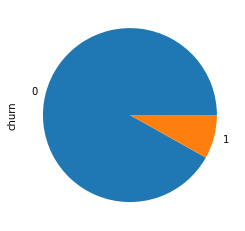

In [43]:
# lets find out churn/non churn percentage
print((telecom_data['churn'].value_counts()/len(telecom_data))*100)
((telecom_data['churn'].value_counts()/len(telecom_data))*100).plot(kind = "pie")
plt.show()

* As we can see that 91% of the customers do not churn, there is a possibility of class imbalance


* Since this variable churn is the target variable, all the columns relating to this variable(i.e. all columns with suffix _9) can be dropped forn the dataset.

In [44]:
# Selecting all the churn phase columns in order to drop then

churn_phase_cols = [col for col in telecom_data.columns if '_9' in col]
print("The columns from churn phase are:\n",churn_phase_cols)

The columns from churn phase are:
 ['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']


In [45]:
# Dropping the selected churn phase columns
telecom_data.drop(churn_phase_cols, axis = 1, inplace = True)

# The curent dimension of the dataset after dropping the churn related columns
telecom_data.shape

(30001, 141)

* We can still clean the data by few possible columns relating to the good phase.

* As we derived few columns in the good phase earlier, we can drop those related columns during creation.

In [46]:
telecom_data.drop(['total_rech_amt_data_6', 'av_rech_amt_data_6',
                   'total_rech_data_6', 'total_rech_amt_6',
                  'total_rech_amt_data_7', 'av_rech_amt_data_7',
                   'total_rech_data_7', 'total_rech_amt_7'], axis = 1, inplace = True)

* We can also create new columns for the defining the good phase variables and drop the seperate 6th and 7 month variables.




#### Before proceding to check the remaining missing value handling, let us check the collineartity of the indepedent variables and try to understand their dependencies.

In [47]:
# creating a list of column names for each month
mon_6_cols = [col for col in telecom_data.columns if '_6' in col]
mon_7_cols = [col for col in telecom_data.columns if '_7' in col]
mon_8_cols = [col for col in telecom_data.columns if '_8' in col]

In [48]:
# lets check the correlation amongst the independent variables, drop the highly correlated ones
telecom_data_corr = telecom_data.corr()
telecom_data_corr.loc[:,:] = np.tril(telecom_data_corr, k=-1)
telecom_data_corr = telecom_data_corr.stack()
telecom_data_corr
telecom_data_corr[(telecom_data_corr > 0.80) | (telecom_data_corr < -0.80)].sort_values(ascending = False)

total_rech_amt_8    arpu_8                0.955351
isd_og_mou_8        isd_og_mou_7          0.943433
                    isd_og_mou_6          0.919641
isd_og_mou_7        isd_og_mou_6          0.916237
sachet_2g_8         total_rech_data_8     0.900629
total_ic_mou_6      loc_ic_mou_6          0.895099
total_ic_mou_8      loc_ic_mou_8          0.893072
total_ic_mou_7      loc_ic_mou_7          0.883070
std_og_t2t_mou_8    onnet_mou_8           0.860483
std_og_t2t_mou_7    onnet_mou_7           0.860275
std_og_t2t_mou_6    onnet_mou_6           0.859593
avg_rech_amt_6_7    overall_rech_amt_7    0.856275
std_og_t2m_mou_7    offnet_mou_7          0.854685
std_og_t2m_mou_8    offnet_mou_8          0.851049
total_og_mou_8      std_og_mou_8          0.848858
total_og_mou_7      std_og_mou_7          0.848825
loc_ic_mou_8        loc_ic_t2m_mou_8      0.847512
std_ic_mou_8        std_ic_t2m_mou_8      0.845590
loc_ic_mou_6        loc_ic_t2m_mou_6      0.844418
loc_og_mou_8        loc_og_mou_

In [49]:
col_to_drop=['total_rech_amt_8', 'isd_og_mou_8', 'isd_og_mou_7', 'sachet_2g_8', 'total_ic_mou_6',
            'total_ic_mou_8', 'total_ic_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_8', 'std_og_t2t_mou_7',
            'std_og_t2m_mou_7', 'std_og_t2m_mou_8',]

# These columns can be dropped as they are highly collinered with other predictor variables.
# criteria set is for collinearity of 85%

#  dropping these column
telecom_data.drop(col_to_drop, axis = 1, inplace = True)

In [50]:
telecom_data.shape

(30001, 121)

## Deriving new variables to understand the data

In [51]:
# We have a column called 'aon'

# we can derive new variables from this to explain the data w.r.t churn.

# creating a new variable 'tenure'
telecom_data['tenure'] = (telecom_data['aon']/30).round(0)

# Since we derived a new column from 'aon', we can drop it
telecom_data.drop('aon', axis = 1, inplace = True)

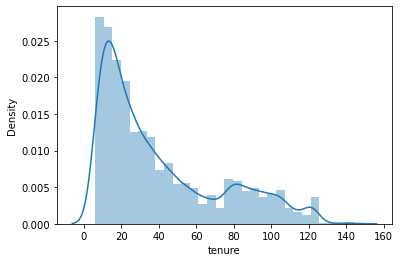

In [52]:
# Checking the distribution of he tenure variable

sns.distplot(telecom_data['tenure'], bins = 30)
plt.show()

In [53]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_data['tenure_range'] = pd.cut(telecom_data['tenure'], tn_range, labels = tn_label)
telecom_data['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

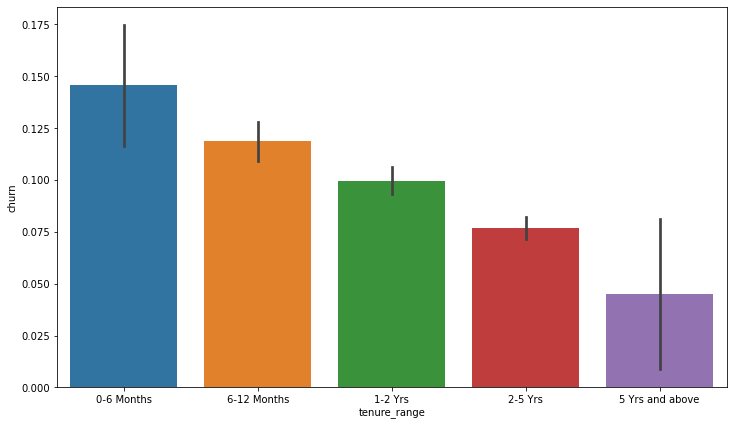

In [54]:
# Plotting a bar plot for tenure range
plt.figure(figsize = [12,7])
sns.barplot(x = 'tenure_range', y = 'churn', data = telecom_data)
plt.show()

* It can be seen that the maximum churn rate happens within 0-6 month, but it gradually decreases as the customer retains in the network.



* The average revenue per user is good phase of customer is given by arpu_6 and arpu_7. since we have two seperate averages, lets take an average to these two and drop the other columns.

In [55]:
telecom_data["avg_arpu_6_7"] = (telecom_data['arpu_6']+telecom_data['arpu_7'])/2
telecom_data['avg_arpu_6_7'].head()

0      206.1005
7     1209.5150
8      435.4720
21     556.1030
23     134.1235
Name: avg_arpu_6_7, dtype: float64

In [56]:
telecom_data.drop(['arpu_6','arpu_7'], axis = 1, inplace = True)


# The curent dimension of the dataset after dropping few unwanted columns
telecom_data.shape

(30001, 121)

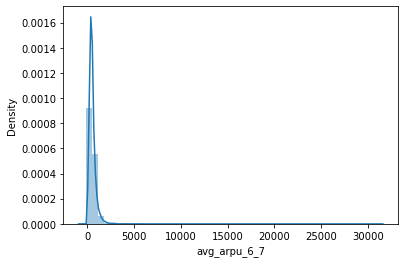

In [57]:
sns.distplot(telecom_data['avg_arpu_6_7'])
plt.show()

Text(0.5, 1.0, 'Features Correlating with Churn variable')

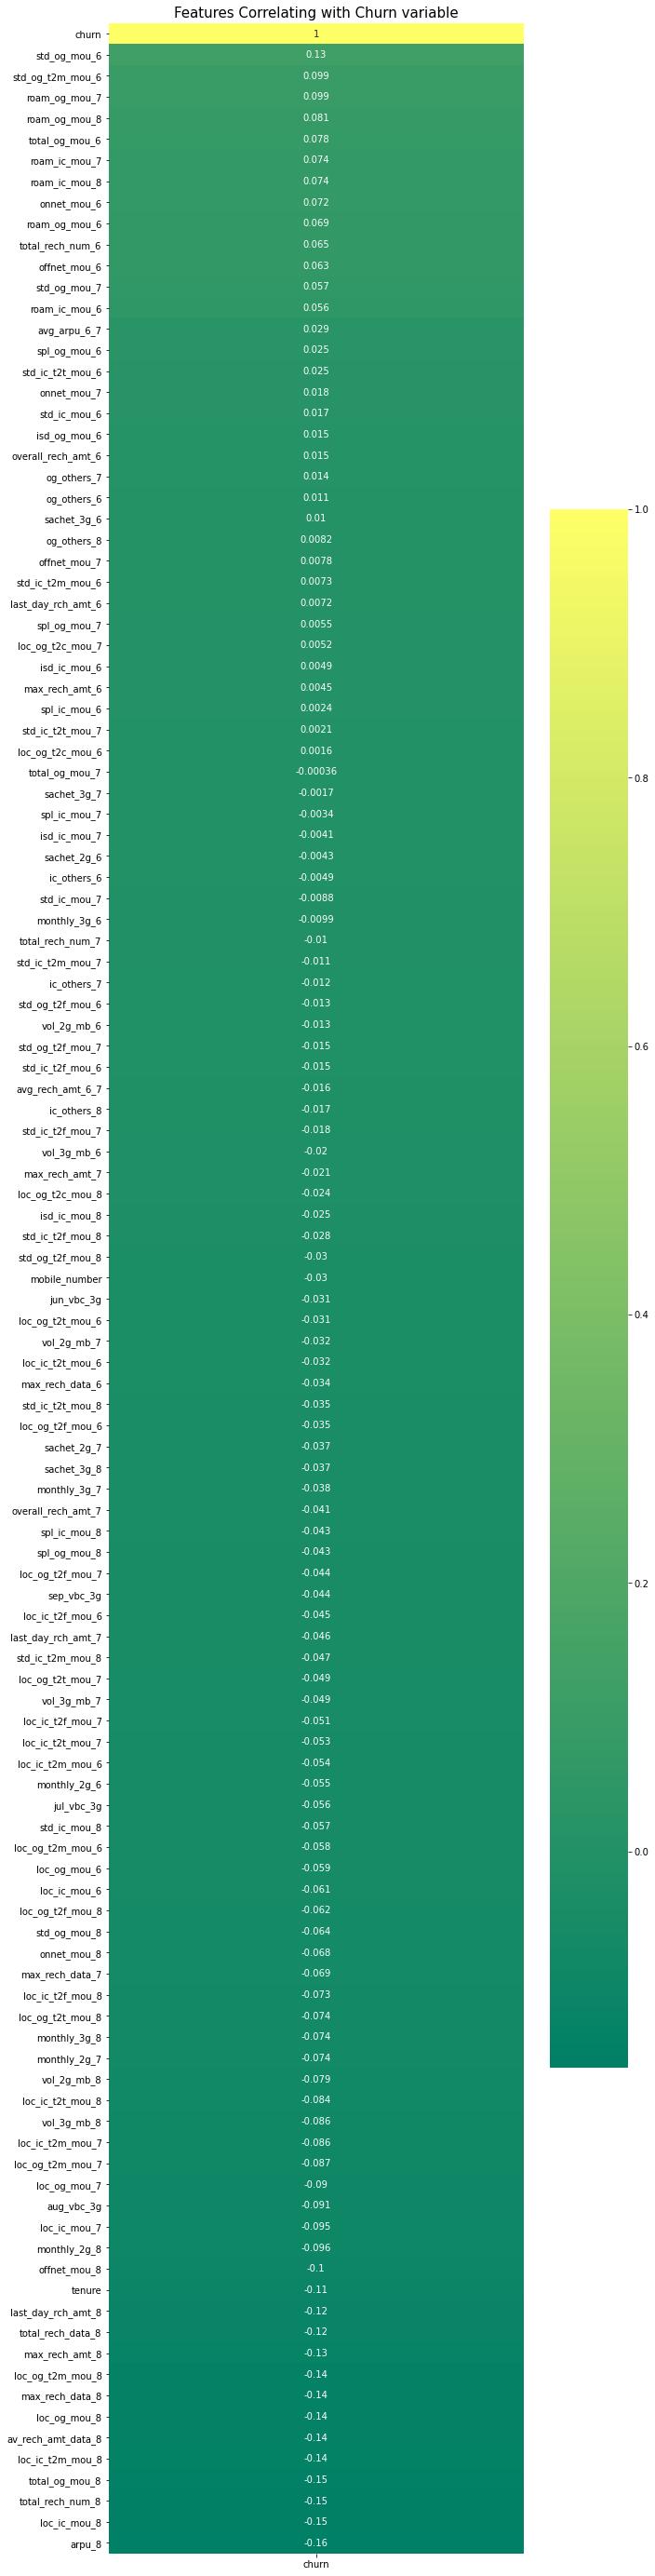

In [58]:
# Checking Correlation between target variable(SalePrice) with the other variable in the dataset
plt.figure(figsize = (10,50))
heatmap_churn = sns.heatmap(telecom_data.corr()[['churn']].sort_values(ascending = False, by = 'churn'), annot = True, 
                                cmap = 'summer')
heatmap_churn.set_title("Features Correlating with Churn variable", fontsize = 15)

* Avg Outgoing Calls & calls on romaning for 6 & 7th months are positively correlated with churn.
* Avg Revenue, No. Of Recharge for 8th month has negative correlation with churn.

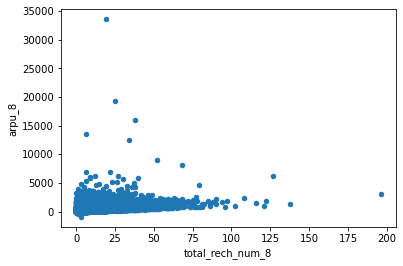

In [59]:
telecom_data[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8', y = 'arpu_8')
plt.show()

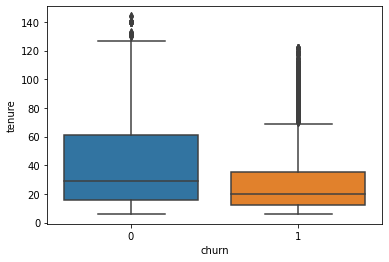

In [60]:
sns.boxplot(x = telecom_data.churn, y = telecom_data.tenure)
plt.show()

* From the above plot , its clear tenured customers do no churn and they keep availing telecom services

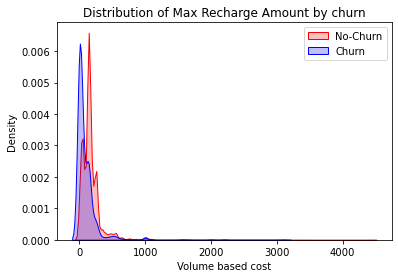

In [61]:
# Plot between churn vs max rechare amount
ax = sns.kdeplot(telecom_data.max_rech_amt_8[(telecom_data["churn"] == 0)], color = "Red", shade = True)
ax = sns.kdeplot(telecom_data.max_rech_amt_8[(telecom_data["churn"] == 1)], ax = ax, color = "Blue", shade = True)
ax.legend(["No-Churn", "Churn"], loc = 'upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')
plt.show()

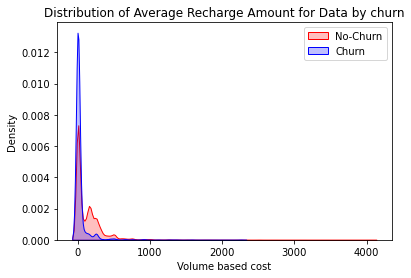

In [62]:
# churn vs max rechare amount
ax = sns.kdeplot(telecom_data.av_rech_amt_data_8[(telecom_data["churn"] == 0)], color = "Red", shade = True)
ax = sns.kdeplot(telecom_data.av_rech_amt_data_8[(telecom_data["churn"] == 1)], ax = ax, color = "Blue", shade = True)
ax.legend(["No-Churn","Churn"], loc = 'upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Average Recharge Amount for Data by churn')
plt.show()

In [63]:
# Creating categories for month 8 column totalrecharge and their count
telecom_data['total_rech_data_group_8'] = pd.cut(telecom_data['total_rech_data_8'], [-1,0,10,25,100], labels = ["No_Recharge", "<=10_Recharges", "10-25_Recharges", ">25_Recharges"])
telecom_data['total_rech_num_group_8'] = pd.cut(telecom_data['total_rech_num_8'], [-1,0,10,25,1000], labels = ["No_Recharge", "<=10_Recharges", "10-25_Recharges", ">25_Recharges"])

					Distribution of total_rech_data_8 variable
 <=10_Recharges     15307
No_Recharge        14048
10-25_Recharges      608
>25_Recharges         38
Name: total_rech_data_group_8, dtype: int64


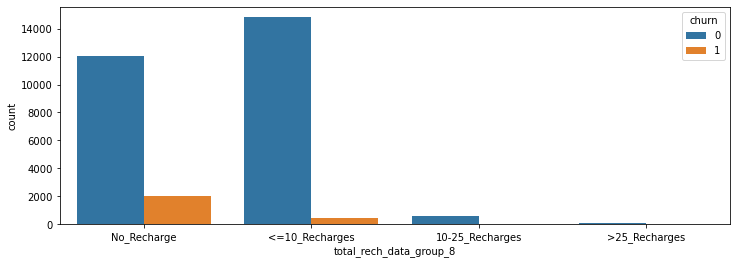

					Distribution of total_rech_num_8 variable
 <=10_Recharges     19349
10-25_Recharges     8073
>25_Recharges       1996
No_Recharge          583
Name: total_rech_num_group_8, dtype: int64


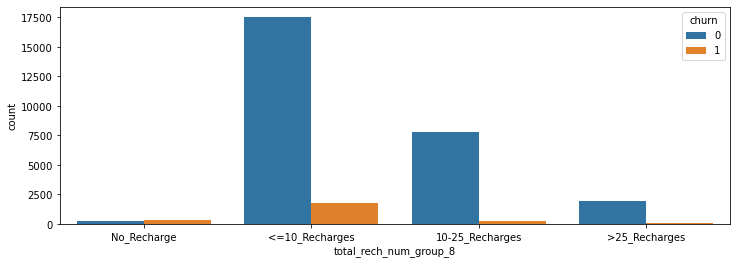

In [64]:
# Plotting the results

plt.figure(figsize = [12,4])
sns.countplot(data = telecom_data, x = "total_rech_data_group_8", hue = "churn")
print("\t\t\t\t\tDistribution of total_rech_data_8 variable\n", telecom_data['total_rech_data_group_8'].value_counts())
plt.show()
plt.figure(figsize = [12,4])
sns.countplot(data = telecom_data, x = "total_rech_num_group_8", hue = "churn")
print("\t\t\t\t\tDistribution of total_rech_num_8 variable\n",telecom_data['total_rech_num_group_8'].value_counts())
plt.show()

* As the number of recharge rate increases, the churn rate decreases clearly.

In [65]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy = pd.get_dummies(telecom_data[['total_rech_data_group_8', 'total_rech_num_group_8', 'tenure_range']], drop_first = True)
dummy.head()

,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,1,0,0,1,0,0,0,0,1,0
7,0,0,0,1,0,0,0,0,1,0
8,1,0,0,0,1,0,1,0,0,0
21,0,0,0,0,0,1,0,1,0,0
23,1,0,0,1,0,0,0,1,0,0


In [66]:
telecom_data = pd.concat([telecom_data, dummy], axis = 1)
telecom_data.head()

,mobile_number,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,...,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,7.000843e+09,213.803,53.27,24.613333,0.00,84.23,23.993333,0.00,0.00,0.00,...,1,0,0,1,0,0,0,0,1,0
7,7.000702e+09,3171.480,57.84,54.680000,52.29,453.43,567.160000,325.91,16.23,33.49,...,0,0,0,1,0,0,0,0,1,0
8,7.001525e+09,137.362,413.69,351.030000,35.08,94.66,80.630000,136.48,0.00,0.00,...,1,0,0,0,1,0,1,0,0,0
21,7.002124e+09,637.760,102.41,132.110000,85.14,757.93,896.680000,983.39,0.00,0.00,...,0,0,0,0,0,1,0,1,0,0
23,7.000887e+09,366.966,48.96,50.660000,33.58,85.41,89.360000,205.89,0.00,0.00,...,1,0,0,1,0,0,0,1,0,0


In [67]:
df=telecom_data[:].copy()

# Dropping unwanted columns
df.drop(['tenure_range', 'mobile_number', 'total_rech_data_group_8', 'total_rech_num_group_8', 'sep_vbc_3g','tenure'], 
        axis = 1, inplace = True)

In [68]:
df.head()

,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,...,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,213.803,53.27,24.613333,0.00,84.23,23.993333,0.00,0.00,0.00,0.00,...,1,0,0,1,0,0,0,0,1,0
7,3171.480,57.84,54.680000,52.29,453.43,567.160000,325.91,16.23,33.49,31.64,...,0,0,0,1,0,0,0,0,1,0
8,137.362,413.69,351.030000,35.08,94.66,80.630000,136.48,0.00,0.00,0.00,...,1,0,0,0,1,0,1,0,0,0
21,637.760,102.41,132.110000,85.14,757.93,896.680000,983.39,0.00,0.00,0.00,...,0,0,0,0,0,1,0,1,0,0
23,366.966,48.96,50.660000,33.58,85.41,89.360000,205.89,0.00,0.00,0.00,...,1,0,0,1,0,0,0,1,0,0


In [69]:
# lets create X dataset for model building.
X = df.drop(['churn'], axis = 1)

In [70]:
X.head()

,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,...,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,213.803,53.27,24.613333,0.00,84.23,23.993333,0.00,0.00,0.00,0.00,...,1,0,0,1,0,0,0,0,1,0
7,3171.480,57.84,54.680000,52.29,453.43,567.160000,325.91,16.23,33.49,31.64,...,0,0,0,1,0,0,0,0,1,0
8,137.362,413.69,351.030000,35.08,94.66,80.630000,136.48,0.00,0.00,0.00,...,1,0,0,0,1,0,1,0,0,0
21,637.760,102.41,132.110000,85.14,757.93,896.680000,983.39,0.00,0.00,0.00,...,0,0,0,0,0,1,0,1,0,0
23,366.966,48.96,50.660000,33.58,85.41,89.360000,205.89,0.00,0.00,0.00,...,1,0,0,1,0,0,0,1,0,0


In [71]:
# lets create y dataset for model building.
y = df['churn']
y.head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int32

In [72]:
# split the dateset into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, train_size = 0.7, random_state = 1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test :", X_test.shape)

Dimension of X_train: (21000, 126)
Dimension of X_test : (9001, 126)


In [73]:
X_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 15709 to 99093
Data columns (total 126 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    arpu_8                                   float64
 1    onnet_mou_6                              float64
 2    onnet_mou_7                              float64
 3    onnet_mou_8                              float64
 4    offnet_mou_6                             float64
 5    offnet_mou_7                             float64
 6    offnet_mou_8                             float64
 7    roam_ic_mou_6                            float64
 8    roam_ic_mou_7                            float64
 9    roam_ic_mou_8                            float64
 10   roam_og_mou_6                            float64
 11   roam_og_mou_7                            float64
 12   roam_og_mou_8                            float64
 13   loc_og_t2t_mou_6                         float64
 14   

In [74]:
num_col = X_train.select_dtypes(include = ['int64','float64']).columns.tolist()

In [75]:
# apply scaling on the dataset
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])

In [76]:
X_train.head()

,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,...,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
15709,0.038904,0.000235,0.000531,0.000238,0.004211,0.003651,0.004095,0.0,0.000000,0.0,...,1,0,0,1,0,0,0,0,0,0
28202,0.032921,0.000493,0.000000,0.000000,0.001631,0.000000,0.000000,0.0,0.000000,0.0,...,1,0,0,1,0,0,0,0,1,0
14943,0.033826,0.000876,0.000275,0.000714,0.003861,0.007485,0.003679,0.0,0.000000,0.0,...,1,0,0,0,1,0,1,0,0,0
92007,0.081645,0.163879,0.105394,0.050406,0.142667,0.177782,0.052962,0.0,0.029033,0.0,...,1,0,0,1,0,0,0,0,1,0
56403,0.042893,0.079633,0.051881,0.004868,0.058346,0.046732,0.010097,0.0,0.000000,0.0,...,0,0,0,0,1,0,0,1,0,0


## Data Imbalance Handling

* Using SMOTE method, we can balance the data w.r.t. churn variable and proceed further

In [77]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [78]:
print("Dimension of X_train_sm Shape:", X_train_sm.shape)
print("Dimension of y_train_sm Shape:", y_train_sm.shape)

Dimension of X_train_sm Shape: (38576, 126)
Dimension of y_train_sm Shape: (38576,)


## Logistic Regression

In [79]:
import statsmodels.api as sm

In [80]:
logm1 = sm.GLM(y_train_sm, (sm.add_constant(X_train_sm)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38450
Model Family:                Binomial   Df Model:                          125
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13899.
Date:                Tue, 17 Aug 2021   Deviance:                       27799.
Time:                        18:44:49   Pearson chi2:                 2.47e+14
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.0696      0.152      7.048      0.000       0.772       1.367
arpu_8                                      4.7856      1.723      2.778      0.005       1.409       8.163
onnet_mou_6                               -51.0285     28.720     -1.777      0.076    -107.319       5.262
onnet_mou_7                                58.2210     16.329      3.565      0.000      26.216      90.226
onnet_mou_8                               181.4643     24.154      7.513      0.000     134.124     228.805
offnet_mou_6                              -47.8874     32.381     -1.479      0.139    -111.352      15.578
offnet_mou_7                               71.5233     19.308      3.704      0.000      33.681     109.365
offnet_mou_8                              232.4309     31.429      7.395      0.000     170.832     294.030
roam_ic_mou_6                               3.0054      0.846      3.552      0.000       1.347       4.664
roam_ic_mou_7                               5.1800      1.573      3.293      0.001       2.097       8.263
roam_ic_mou_8                              -1.5652      0.802     -1.952      0.051      -3.137       0.006
roam_og_mou_6                              21.8398     14.674      1.488      0.137      -6.921      50.601
roam_og_mou_7                             -12.2597      3.827     -3.204      0.001     -19.760      -4.759
roam_og_mou_8                             -55.8880      7.814     -7.152      0.000     -71.203     -40.573
loc_og_t2t_mou_6                        -6949.0002   1.98e+04     -0.352      0.725   -4.57e+04    3.18e+04
loc_og_t2t_mou_7                        -1.823e+04   2.28e+04     -0.800      0.424   -6.29e+04    2.64e+04
loc_og_t2t_mou_8                          1.93e+05   3.41e+04      5.662      0.000    1.26e+05     2.6e+05
loc_og_t2m_mou_6                        -5118.4840   1.45e+04     -0.352      0.725   -3.36e+04    2.34e+04
loc_og_t2m_mou_7                        -1.099e+04   1.37e+04     -0.800      0.424   -3.79e+04    1.59e+04
loc_og_t2m_mou_8                         6.367e+04   1.12e+04      5.662      0.000    4.16e+04    8.57e+04
loc_og_t2f_mou_6                         -729.5972   2078.281     -0.351      0.726   -4802.954    3343.759
loc_og_t2f_mou_7                        -2621.4631   3259.130     -0.804      0.421   -9009.241    3766.315
loc_og_t2f_mou_8                         1.667e+04   2943.364      5.664      0.000    1.09e+04    2.24e+04
loc_og_t2c_mou_6                           -5.0019      1.068     -4.685      0.000      -7.094      -2.910
loc_og_t2c_mou_7                            0.2131      1.863      0.114      0.909      -3.439       3.865
loc_og_t2c_mou_8                            0.3722      1.2

## Logistic Regression using Feature Selection (RFE method)

In [81]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE

# running RFE with 20 variables as output
rfe = RFE(logreg, 20)             
rfe = rfe.fit(X_train_sm, y_train_sm)

In [82]:
rfe.support_

array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False])

In [83]:
rfe_columns = X_train_sm.columns[rfe.support_]
print("The selected columns by RFE for modelling are: \n\n", rfe_columns)

The selected columns by RFE for modelling are: 

 Index(['arpu_8', 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_8',
       'std_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_8', 'std_ic_mou_8',
       'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8',
       'monthly_2g_8', 'aug_vbc_3g', 'avg_arpu_6_7'],
      dtype='object')


In [84]:
list(zip(X_train_sm.columns, rfe.support_, rfe.ranking_))

[('arpu_8', True, 1),
 ('onnet_mou_6', False, 22),
 ('onnet_mou_7', False, 37),
 ('onnet_mou_8', False, 42),
 ('offnet_mou_6', False, 35),
 ('offnet_mou_7', False, 21),
 ('offnet_mou_8', False, 26),
 ('roam_ic_mou_6', False, 13),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 60),
 ('roam_og_mou_6', False, 69),
 ('roam_og_mou_7', False, 33),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 65),
 ('loc_og_t2t_mou_7', False, 99),
 ('loc_og_t2t_mou_8', False, 19),
 ('loc_og_t2m_mou_6', False, 67),
 ('loc_og_t2m_mou_7', False, 74),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 107),
 ('loc_og_t2f_mou_7', False, 5),
 ('loc_og_t2f_mou_8', False, 25),
 ('loc_og_t2c_mou_6', False, 7),
 ('loc_og_t2c_mou_7', False, 66),
 ('loc_og_t2c_mou_8', False, 104),
 ('loc_og_mou_6', False, 48),
 ('loc_og_mou_7', False, 105),
 ('loc_og_mou_8', False, 2),
 ('std_og_t2m_mou_6', False, 93),
 ('std_og_t2f_mou_6', False, 79),
 ('std_og_t2f_mou_7', False, 27),
 ('std_og_t2f_mou_8',

### Assessing the model with StatsModels

In [85]:
X_train_SM = sm.add_constant(X_train_sm[rfe_columns])
logm2 = sm.GLM(y_train_sm,X_train_SM, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38555
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15852.
Date:                Tue, 17 Aug 2021   Deviance:                       31703.
Time:                        18:45:40   Pearson chi2:                 8.44e+10
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5718      0.071      8.101      0.000       0.433       0.710
arpu_8                -7.4189      1.295     -5.730      0.000      -9.957      -4.881
roam_ic_mou_7          8.3147      0.929      8.948      0.000       6.493      10.136
roam_og_mou_8          4.3254      0.602      7.190      0.000       3.146       5.505
loc_og_t2m_mou_8      -3.8292      0.668     -5.731      0.000      -5.139      -2.520
std_og_mou_7           7.7463      0.513     15.114      0.000       6.742       8.751
total_og_mou_8       -20.2090      0.956    -21.143      0.000     -22.082     -18.336
loc_ic_t2t_mou_8       1.0280      4.078      0.252      0.801      -6.966       9.022
loc_ic_t2m_mou_8      -1.2611      4.448     -0.284      0.777      -9.978       7.456
loc_ic_mou_6           9.1611      0.723     12.666      0.000       7.743      10.579
loc_ic_mou_8         -31.0473      5.010     -6.197      0.000     -40.866     -21.228
std_ic_mou_8         -11.9357      1.359     -8.784      0.000     -14.599      -9.272
spl_ic_mou_8         -19.8516      1.375    -14.436      0.000     -22.547     -17.156
total_rech_num_8      -7.0996      0.533    -13.327      0.000      -8.144      -6.055
last_day_rch_amt_8   -18.3227      0.810    -22.610      0.000     -19.911     -16.734
total_rech_data_8     -8.9207      0.612    -14.580      0.000     -10.120      -7.721
av_rech_amt_data_8    -5.2450      0.644     -8.148      0.000      -6.507      -3.983
vol_2g_mb_8          -10.4892      0.934    -11.229      0.000     -12.320      -8.658
monthly_2g_8          -5.7717      0.360    -16.041      0.000      -6.477      -5.066
aug_vbc_3g            -6.8396      0.588    -11.633      0.000      -7.992      -5.687
avg_arpu_6_7          18.2676      1.089     16.781      0.000      16.134      20.401
======================================================================================
"""

In [86]:
# From the p-value of the individual columns, 
    # we can drop the column 'loc_ic_t2t_mou_8' as it has high p-value of 0.80
rfe_columns_1 = rfe_columns.drop('loc_ic_t2t_mou_8', 1)
print("\nThe new set of edited featured are:\n", rfe_columns_1)


The new set of edited featured are:
 Index(['arpu_8', 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_8',
       'std_og_mou_7', 'total_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'monthly_2g_8', 'aug_vbc_3g', 'avg_arpu_6_7'],
      dtype='object')


In [87]:
# Training the model with the edited feature list
X_train_SM = sm.add_constant(X_train_sm[rfe_columns_1])
logm2 = sm.GLM(y_train_sm, X_train_SM, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38556
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15852.
Date:                Tue, 17 Aug 2021   Deviance:                       31703.
Time:                        18:45:40   Pearson chi2:                 8.49e+10
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5714      0.071      8.096      0.000       0.433       0.710
arpu_8                -7.4196      1.295     -5.730      0.000      -9.957      -4.882
roam_ic_mou_7          8.3174      0.929      8.950      0.000       6.496      10.139
roam_og_mou_8          4.3268      0.602      7.192      0.000       3.148       5.506
loc_og_t2m_mou_8      -3.8309      0.668     -5.734      0.000      -5.140      -2.521
std_og_mou_7           7.7428      0.512     15.114      0.000       6.739       8.747
total_og_mou_8       -20.2018      0.955    -21.146      0.000     -22.074     -18.329
loc_ic_t2m_mou_8      -2.2429      2.136     -1.050      0.294      -6.429       1.943
loc_ic_mou_6           9.1640      0.723     12.669      0.000       7.746      10.582
loc_ic_mou_8         -29.8843      1.933    -15.463      0.000     -33.672     -26.096
std_ic_mou_8         -11.9422      1.359     -8.789      0.000     -14.605      -9.279
spl_ic_mou_8         -19.8488      1.375    -14.435      0.000     -22.544     -17.154
total_rech_num_8      -7.0935      0.532    -13.330      0.000      -8.136      -6.051
last_day_rch_amt_8   -18.3273      0.810    -22.622      0.000     -19.915     -16.739
total_rech_data_8     -8.9222      0.612    -14.583      0.000     -10.121      -7.723
av_rech_amt_data_8    -5.2484      0.644     -8.155      0.000      -6.510      -3.987
vol_2g_mb_8          -10.4886      0.934    -11.228      0.000     -12.320      -8.658
monthly_2g_8          -5.7723      0.360    -16.043      0.000      -6.478      -5.067
aug_vbc_3g            -6.8433      0.588    -11.642      0.000      -7.995      -5.691
avg_arpu_6_7          18.2734      1.088     16.790      0.000      16.140      20.406
======================================================================================
"""

In [88]:
# From the p-value of the individual columns, 
    # we can drop the column 'loc_ic_t2m_mou_8' as it has high p-value of 0.80
rfe_columns_2 = rfe_columns_1.drop('loc_ic_t2m_mou_8', 1)
print("\nThe new set of edited featured are:\n", rfe_columns_2)


The new set of edited featured are:
 Index(['arpu_8', 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_8',
       'std_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_8',
       'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'av_rech_amt_data_8',
       'vol_2g_mb_8', 'monthly_2g_8', 'aug_vbc_3g', 'avg_arpu_6_7'],
      dtype='object')


In [89]:
# Training the model with the edited feature list
X_train_SM = sm.add_constant(X_train_sm[rfe_columns_2])
logm2 = sm.GLM(y_train_sm,X_train_SM, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38576
Model:                            GLM   Df Residuals:                    38557
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15852.
Date:                Tue, 17 Aug 2021   Deviance:                       31704.
Time:                        18:45:40   Pearson chi2:                 8.51e+10
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5682      0.071      8.055      0.000       0.430       0.706
arpu_8                -7.3871      1.294     -5.709      0.000      -9.923      -4.851
roam_ic_mou_7          8.2919      0.930      8.919      0.000       6.470      10.114
roam_og_mou_8          4.3369      0.602      7.208      0.000       3.158       5.516
loc_og_t2m_mou_8      -3.9987      0.650     -6.156      0.000      -5.272      -2.725
std_og_mou_7           7.7052      0.511     15.082      0.000       6.704       8.707
total_og_mou_8       -20.1259      0.952    -21.139      0.000     -21.992     -18.260
loc_ic_mou_6           9.1605      0.724     12.652      0.000       7.741      10.580
loc_ic_mou_8         -31.5914      1.068    -29.592      0.000     -33.684     -29.499
std_ic_mou_8         -11.9423      1.359     -8.790      0.000     -14.605      -9.280
spl_ic_mou_8         -19.8518      1.375    -14.440      0.000     -22.546     -17.157
total_rech_num_8      -7.1243      0.531    -13.408      0.000      -8.166      -6.083
last_day_rch_amt_8   -18.3312      0.810    -22.622      0.000     -19.919     -16.743
total_rech_data_8     -8.9197      0.612    -14.580      0.000     -10.119      -7.721
av_rech_amt_data_8    -5.2486      0.644     -8.155      0.000      -6.510      -3.987
vol_2g_mb_8          -10.5014      0.934    -11.242      0.000     -12.332      -8.671
monthly_2g_8          -5.7637      0.360    -16.025      0.000      -6.469      -5.059
aug_vbc_3g            -6.8479      0.588    -11.651      0.000      -8.000      -5.696
avg_arpu_6_7          18.3112      1.088     16.823      0.000      16.178      20.445
======================================================================================
"""

In [90]:
# Getting the predicted values on the train set
y_train_sm_pred = res.predict(X_train_SM)
y_train_sm_pred = y_train_sm_pred.values.reshape(-1)
y_train_sm_pred[:10]

array([1.38574250e-01, 4.01121753e-01, 3.24275768e-01, 4.14619020e-01,
       5.08729618e-01, 4.31066021e-01, 2.12010834e-05, 2.27844968e-01,
       5.14992869e-02, 7.08374581e-01])

### Creating a dataframe with the actual churn flag and the predicted probabilities

In [91]:
y_train_sm_pred_final = pd.DataFrame({'Converted':y_train_sm.values, 'Converted_prob':y_train_sm_pred})
y_train_sm_pred_final.head()

,Converted,Converted_prob
0,0,0.138574
1,0,0.401122
2,0,0.324276
3,0,0.414619
4,0,0.508730


### Creating new column 'churn_pred' with 1 if Churn_Prob > 0.5 else 0

In [92]:
y_train_sm_pred_final['churn_pred'] = y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Viewing the prediction results
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred
0,0,0.138574,0
1,0,0.401122,0
2,0,0.324276,0
3,0,0.414619,0
4,0,0.508730,1


In [93]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred )
print(confusion)

[[15661  3627]
 [ 2775 16513]]


In [94]:
print("The overall accuracy of the model is:", metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred))

The overall accuracy of the model is: 0.8340418913313977


In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [96]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_sm[rfe_columns_2].columns
vif['VIF'] = [variance_inflation_factor(X_train_sm[rfe_columns].values, i) for i in range(X_train_sm[rfe_columns_2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,spl_ic_mou_8,83.90
7,loc_ic_mou_8,42.86
0,arpu_8,18.96
6,loc_ic_mou_6,18.68
5,total_og_mou_8,5.46
12,total_rech_data_8,3.58
4,std_og_mou_7,3.27
8,std_ic_mou_8,2.88
15,monthly_2g_8,2.76
3,loc_og_t2m_mou_8,2.54


## Metrics beyond simply accuracy

In [97]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [98]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity = ",TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP/ float(TN+FP))

# positive predictive value 
print ("Precision = ",TP / float(TP+FP))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN / float(TN+ FN))

Sensitivity =  0.8561281625881377
Specificity =  0.8119556200746578
False Positive Rate =  0.18804437992534218
Precision =  0.8199106256206554
True Negative Prediction Rate =  0.8494792796702104


## Plotting the ROC Curve

In [99]:
# Defining a function to plot the roc curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize = (5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Prediction Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [100]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob, drop_intermediate = False )

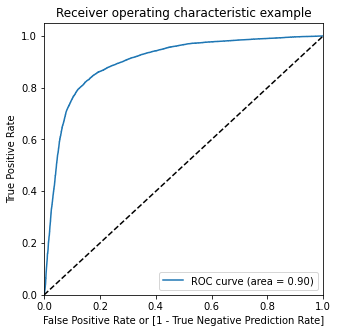

In [101]:
draw_roc(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

### Finding Optimal Cutoff Point

In [102]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_sm_pred_final[i] = y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.138574,0,1,1,0,0,0,0,0,0,0,0
1,0,0.401122,0,1,1,1,1,1,0,0,0,0,0
2,0,0.324276,0,1,1,1,1,0,0,0,0,0,0
3,0,0.414619,0,1,1,1,1,1,0,0,0,0,0
4,0,0.508730,1,1,1,1,1,1,1,0,0,0,0


In [103]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     1.000000     0.000000
0.1          0.1  0.686696     0.977603     0.395790
0.2          0.2  0.751996     0.957538     0.546454
0.3          0.3  0.791321     0.925653     0.656989
0.4          0.4  0.816881     0.891176     0.742586
0.5          0.5  0.834042     0.856128     0.811956
0.6          0.6  0.836116     0.805682     0.866549
0.7          0.7  0.820795     0.730350     0.911240
0.8          0.8  0.755003     0.561230     0.948776
0.9          0.9  0.614294     0.248185     0.980402


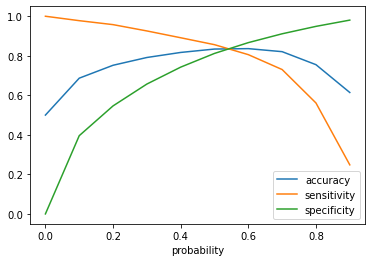

In [104]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x = 'probability', y = ['accuracy', 'sensitivity', 'specificity'])
plt.show()

* Initially we selected the optimm point of classification as 0.5.



* From the above graph, we can see the optimum cutoff is slightly higher than 0.5 but lies lower than 0.6. So lets tweek a little more within this range.

In [105]:
numbers = [0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]
for i in numbers:
    y_train_sm_pred_final[i] = y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.9,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59
0,0,0.138574,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.401122,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.324276,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.414619,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.508730,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability', 'accuracy', 'sensitivity', 'specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

      probability  accuracy  sensitivity  specificity
0.50         0.50  0.834042     0.856128     0.811956
0.51         0.51  0.835001     0.851669     0.818333
0.52         0.52  0.835675     0.846796     0.824554
0.53         0.53  0.836038     0.841611     0.830465
0.54         0.54  0.836245     0.836375     0.836116
0.55         0.55  0.836064     0.830983     0.841145
0.56         0.56  0.837075     0.826991     0.847159
0.57         0.57  0.837179     0.821910     0.852447
0.58         0.58  0.836219     0.815896     0.856543
0.59         0.59  0.835831     0.810452     0.861209


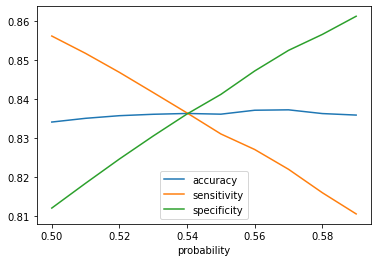

In [107]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x = 'probability', y = ['accuracy', 'sensitivity', 'specificity'])
plt.show()

* From the above graph we can conclude, the optimal cutoff point in the probability to define the predicted churn variabe converges at 0.54

In [108]:
#### From the curve above, 0.2 is the optimum point to take it as a cutoff probability.

y_train_sm_pred_final['final_churn_pred'] = y_train_sm_pred_final.Converted_prob.map( lambda x: 1 if x > 0.54 else 0)

y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,...,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,final_churn_pred
0,0,0.138574,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.401122,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.324276,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.414619,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.508730,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
print("The overall accuracy of the model now is:", metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred))

The overall accuracy of the model now is: 0.8362453338863542


In [110]:
confusion2 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred )
print(confusion2)

[[16127  3161]
 [ 3156 16132]]


In [111]:
TP2 = confusion2[1,1] # true positive 
TN2 = confusion2[0,0] # true negatives
FP2 = confusion2[0,1] # false positives
FN2 = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP2 / float(TP2+FN2))

# Let us calculate specificity
print("Specificity = ",TN2 / float(TN2+FP2))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP2/ float(TN2+FP2))

# positive predictive value 
print ("Precision = ",TP2 / float(TP2+FP2))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN2 / float(TN2 + FN2))

Sensitivity =  0.8363749481542928
Specificity =  0.8361157196184156
False Positive Rate =  0.1638842803815844
Precision =  0.8361581920903954
True Negative Prediction Rate =  0.8363325208733081


## Precision and recall tradeoff

In [112]:
from sklearn.metrics import precision_recall_curve

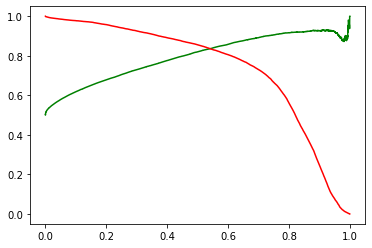

In [113]:
p, r, thresholds = precision_recall_curve(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

# Plotting the curve
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

## Making predictions on the test set

* Transforming and feature selection for test data

In [114]:
# Scaling the test data
X_test[num_col] = scaler.transform(X_test[num_col])
X_test.head()

,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,...,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
35865,0.026143,0.021027,0.000000,0.000070,0.003412,0.000575,0.000000,0.0,0.000000,0.000000,...,0,0,0,1,0,0,1,0,0,0
41952,0.048190,0.005702,0.005250,0.002058,0.011146,0.023873,0.007510,0.0,0.000000,0.000000,...,1,0,0,1,0,0,0,0,1,0
98938,0.061230,0.003275,0.037889,0.008157,0.010851,0.025458,0.018789,0.0,0.000000,0.000000,...,1,0,0,1,0,0,0,0,0,0
29459,0.042998,0.020180,0.000963,0.000297,0.001588,0.003828,0.000573,0.0,0.000000,0.000000,...,1,0,0,1,0,0,1,0,0,0
70682,0.098384,0.005699,0.011111,0.039505,0.084425,0.242612,0.135335,0.0,0.000721,0.000521,...,1,0,0,0,1,0,0,1,0,0


In [115]:
# Feature selection
X_test=X_test[rfe_columns_2]
X_test.head()

,arpu_8,roam_ic_mou_7,roam_og_mou_8,loc_og_t2m_mou_8,std_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_8,std_ic_mou_8,spl_ic_mou_8,total_rech_num_8,last_day_rch_amt_8,total_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,monthly_2g_8,aug_vbc_3g,avg_arpu_6_7
35865,0.026143,0.000000,0.000000,0.000000,0.000000,0.000053,0.003321,0.002782,0.009587,0.000000,0.010204,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.059622
41952,0.048190,0.000000,0.000000,0.005379,0.018971,0.009067,0.023235,0.022029,0.008684,0.000000,0.020408,0.011238,0.017544,0.035705,0.004586,0.0,0.019572,0.075152
98938,0.061230,0.000000,0.000000,0.073716,0.000374,0.024987,0.057580,0.183375,0.003706,0.000000,0.035714,0.029220,0.035088,0.124107,0.056568,0.0,0.211621,0.095894
29459,0.042998,0.000000,0.000000,0.000000,0.000000,0.000800,0.001622,0.000037,0.011386,0.000000,0.025510,0.034615,0.052632,0.063039,0.008221,0.2,0.068735,0.070960
70682,0.098384,0.000721,0.031491,0.041749,0.172443,0.157573,0.021147,0.066205,0.002352,0.080257,0.061224,0.029220,0.017544,0.005664,0.000000,0.0,0.000000,0.101081


In [116]:
# Adding constant to the test model.
X_test_SM = sm.add_constant(X_test)

### Predicting the target variable

In [117]:
y_test_pred = res.predict(X_test_SM)
print("\n The first ten probability value of the prediction are:\n", y_test_pred[:10])


 The first ten probability value of the prediction are:
 35865    0.772260
41952    0.516558
98938    0.000325
29459    0.128443
70682    0.007754
58317    0.237200
4860     0.007990
16890    0.702931
61329    0.652452
94332    0.491091
dtype: float64


In [118]:
y_pred = pd.DataFrame(y_test_pred)
y_pred.head()

,0
35865,0.772260
41952,0.516558
98938,0.000325
29459,0.128443
70682,0.007754


In [119]:
y_pred = y_pred.rename(columns = {0:"Conv_prob"})

In [120]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
35865,0
41952,0
98938,0
29459,0
70682,0


In [121]:
y_pred_final = pd.concat([y_test_df, y_pred], axis = 1)
y_pred_final.head()

,churn,Conv_prob
35865,0,0.772260
41952,0,0.516558
98938,0,0.000325
29459,0,0.128443
70682,0,0.007754


In [122]:
y_pred_final['test_churn_pred'] = y_pred_final.Conv_prob.map(lambda x: 1 if x>0.54 else 0)
y_pred_final.head()

,churn,Conv_prob,test_churn_pred
35865,0,0.772260,1
41952,0,0.516558,0
98938,0,0.000325,0
29459,0,0.128443,0
70682,0,0.007754,0


In [123]:
# Checking the overall accuracy of the predicted set.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.test_churn_pred)

0.8270192200866571

## Metrics Evaluation

In [124]:
# Confusion Matrix
confusion2_test = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.test_churn_pred)
print("Confusion Matrix\n", confusion2_test)

Confusion Matrix
 [[6860 1412]
 [ 145  584]]


In [125]:
# Calculating model validation parameters
TP3 = confusion2_test[1,1] # true positive 
TN3 = confusion2_test[0,0] # true negatives
FP3 = confusion2_test[0,1] # false positives
FN3 = confusion2_test[1,0] # false negatives

In [126]:
# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP3 / float(TP3+FN3))

# Let us calculate specificity
print("Specificity = ",TN3 / float(TN3+FP3))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP3/ float(TN3+FP3))

# positive predictive value 
print ("Precision = ",TP3 / float(TP3+FP3))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN3 / float(TN3+FN3))

Sensitivity =  0.8010973936899863
Specificity =  0.8293036750483559
False Positive Rate =  0.1706963249516441
Precision =  0.2925851703406814
True Negative Prediction Rate =  0.979300499643112


## Explaining the results

In [127]:
print("The accuracy of the predicted model is   : ", round(metrics.accuracy_score(y_pred_final.churn, y_pred_final.test_churn_pred), 2)*100,"%")
print("The sensitivity of the predicted model is: ", round(TP3 / float(TP3+FN3), 2)*100,"%")

print("\nAs the model created is based on a sentivity model, i.e. the True positive rate is given more importance as the actual and prediction of churn by a customer\n") 

The accuracy of the predicted model is   :  83.0 %
The sensitivity of the predicted model is:  80.0 %

As the model created is based on a sentivity model, i.e. the True positive rate is given more importance as the actual and prediction of churn by a customer



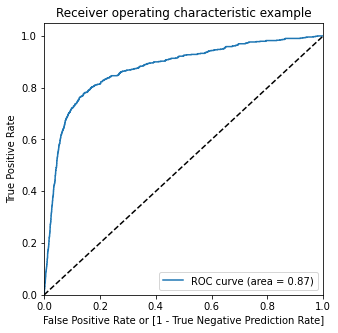

In [128]:
# ROC curve for the test dataset

# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve(y_pred_final.churn, y_pred_final.Conv_prob, drop_intermediate = False )
# Plotting the curve for the obtained metrics
draw_roc(y_pred_final.churn, y_pred_final.Conv_prob)

* The AUC score for train dataset is 0.90 and the test dataset is 0.87.
* This model can be considered as a good model.

## Logistic Regression using PCA

In [129]:
# split the dateset into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, train_size = 0.7, random_state = 1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test :", X_test.shape)

# apply scaling on the dataset

scaler = MinMaxScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

# Applying SMOTE technique for data imbalance correction

sm = SMOTE(random_state = 42)
X_train_sm,y_train_sm = sm.fit_resample(X_train, y_train)
print("Dimension of X_train_sm Shape:", X_train_sm.shape)
print("Dimension of y_train_sm Shape:", y_train_sm.shape)

X_train_sm.head()

Dimension of X_train: (21000, 126)
Dimension of X_test : (9001, 126)
Dimension of X_train_sm Shape: (38576, 126)
Dimension of y_train_sm Shape: (38576,)


,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,...,total_rech_data_group_8_<=10_Recharges,total_rech_data_group_8_10-25_Recharges,total_rech_data_group_8_>25_Recharges,total_rech_num_group_8_<=10_Recharges,total_rech_num_group_8_10-25_Recharges,total_rech_num_group_8_>25_Recharges,tenure_range_6-12 Months,tenure_range_1-2 Yrs,tenure_range_2-5 Yrs,tenure_range_5 Yrs and above
0,0.038904,0.000235,0.000531,0.000238,0.004211,0.003651,0.004095,0.0,0.000000,0.0,...,1,0,0,1,0,0,0,0,0,0
1,0.032921,0.000493,0.000000,0.000000,0.001631,0.000000,0.000000,0.0,0.000000,0.0,...,1,0,0,1,0,0,0,0,1,0
2,0.033826,0.000876,0.000275,0.000714,0.003861,0.007485,0.003679,0.0,0.000000,0.0,...,1,0,0,0,1,0,1,0,0,0
3,0.081645,0.163879,0.105394,0.050406,0.142667,0.177782,0.052962,0.0,0.029033,0.0,...,1,0,0,1,0,0,0,0,1,0
4,0.042893,0.079633,0.051881,0.004868,0.058346,0.046732,0.010097,0.0,0.000000,0.0,...,0,0,0,0,1,0,0,1,0,0


In [130]:
# importing PCA
from sklearn.decomposition import PCA
pca = PCA(random_state = 42)

# applying PCA on train data
pca.fit(X_train_sm)

PCA(random_state=42)

In [131]:
X_train_sm_pca = pca.fit_transform(X_train_sm)
print("Dimension of X_train_sm_pca: ", X_train_sm_pca.shape)

X_test_pca = pca.transform(X_test)
print("Dimension of X_test_pca    : ", X_test_pca.shape)

Dimension of X_train_sm_pca:  (38576, 126)
Dimension of X_test_pca    :  (9001, 126)


In [132]:
#Viewing the PCA components
pca.components_

array([[ 1.77080250e-02,  5.62945551e-03,  1.28071557e-02, ...,
        -8.33377373e-02,  2.03169293e-01, -2.25884463e-04],
       [ 1.17884332e-03,  1.36226801e-04,  2.66567649e-03, ...,
         6.62002105e-01, -7.17541378e-01,  1.93966990e-04],
       [ 8.31908962e-03, -2.32698646e-02, -1.53378013e-02, ...,
         7.54642802e-02,  5.50287343e-02,  1.26734621e-03],
       ...,
       [-3.94307291e-07,  1.32661563e-06, -2.21287988e-06, ...,
        -3.76725866e-08, -1.42403279e-08,  2.74517957e-08],
       [ 2.29473385e-07, -1.88640723e-06,  1.53383133e-06, ...,
        -3.64244933e-08, -2.71775062e-08, -3.24942341e-08],
       [-0.00000000e+00,  4.27813379e-16, -3.56828511e-16, ...,
         4.52749631e-18,  3.69845080e-18, -2.70099221e-18]])

## Performing Logistic Regression

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg_pca = LogisticRegression()
logreg_pca.fit(X_train_sm_pca, y_train_sm)

# making the predictions
y_pred = logreg_pca.predict(X_test_pca)

# converting the prediction into a dataframe
y_pred_df = pd.DataFrame(y_pred)
print("Dimension of y_pred_df:", y_pred_df.shape)

Dimension of y_pred_df: (9001, 1)


In [134]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Checking the Confusion matrix
print("Confusion Matirx for y_test & y_pred\n", confusion_matrix(y_test, y_pred),"\n")

# Checking the Accuracy of the Predicted model.
print("Accuracy of the logistic regression model with PCA: ",accuracy_score(y_test, y_pred))

Confusion Matirx for y_test & y_pred
 [[6760 1512]
 [ 126  603]] 

Accuracy of the logistic regression model with PCA:  0.8180202199755583


* Accuracy of the logistic regression model with PCA:  0.818131318742362

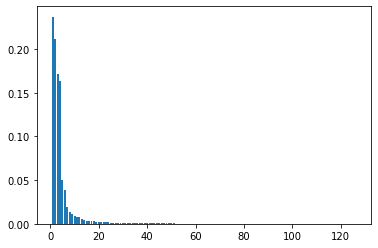

In [135]:
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.show()

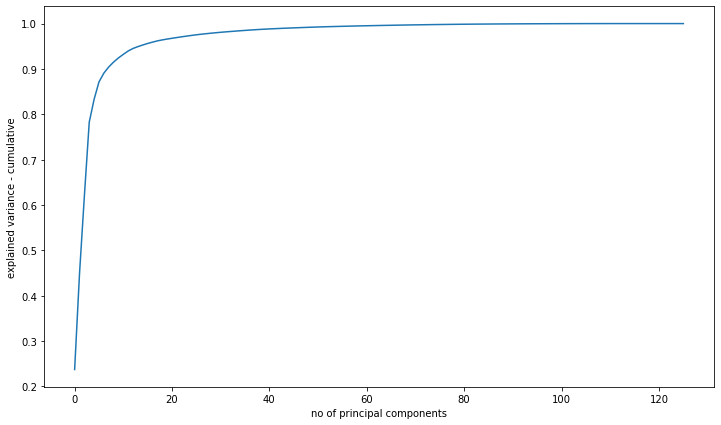

In [136]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

# Making a scree plot
fig = plt.figure(figsize = [12,7])
plt.plot(var_cumu)
plt.xlabel('no of principal components')
plt.ylabel('explained variance - cumulative')
plt.show()

In [137]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 3)*100)

array([23.7, 44.8, 62. , 78.3, 83.3, 87.1, 89. , 90.4, 91.5, 92.4, 93.2,
       93.9, 94.5, 94.9, 95.3, 95.6, 95.9, 96.2, 96.4, 96.6, 96.8, 97. ,
       97.2, 97.4, 97.5, 97.6, 97.7, 97.8, 97.9, 98. , 98.1, 98.2, 98.3,
       98.4, 98.5, 98.6, 98.7, 98.8, 98.9, 99. , 99.1, 99.2, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3, 99.3,
       99.3, 99.3, 99.3, 99.3, 99.3])

* 90% of the data can be explained with 8 PCA components


### Fitting the dataset with the 8 explainable components

In [138]:
pca_8 = PCA(n_components = 15)

train_pca_8 = pca_8.fit_transform(X_train_sm)
print("Dimension for Train dataset using PCA: ", train_pca_8.shape)

test_pca_8 = pca_8.transform(X_test)
print("Dimension for Test dataset using PCA: ", test_pca_8.shape)

Dimension for Train dataset using PCA:  (38576, 15)
Dimension for Test dataset using PCA:  (9001, 15)


In [139]:
logreg_pca_8 = LogisticRegression()
logreg_pca_8.fit(train_pca_8, y_train_sm)

# making the predictions
y_pred_8 = logreg_pca_8.predict(test_pca_8)

# converting the prediction into a dataframe
y_pred_df_8 = pd.DataFrame(y_pred_8)
print("Dimension of y_pred_df_8: ", y_pred_df_8.shape)

Dimension of y_pred_df_8:  (9001, 1)


In [140]:
# Checking the Confusion matrix
print("Confusion Matirx for y_test & y_pred\n", confusion_matrix(y_test, y_pred_8),"\n")

# Checking the Accuracy of the Predicted model.
print("Accuracy of the logistic regression model with PCA: ", accuracy_score(y_test, y_pred_8))

Confusion Matirx for y_test & y_pred
 [[6250 2022]
 [ 185  544]] 

Accuracy of the logistic regression model with PCA:  0.7548050216642596


* Accuracy of the logistic regression model with PCA:  0.7548050216642596

## Inferences and Recommendations:

* A few inferences derived from the Decision Tree:

      * total_ic_mou_8 <= 0.185; 
      * av_rech_amt_data_8 <= 146.0; 
      * std_og_mou_8 <= 287.905; 
      * loc_ic_mou_8 <= 0.105; 
      * avg_vbc_3g_diff <= -71.943;
      * loc_og_mou_7<= 923.11 ========> customer is most likely to churn
      

      * total_ic_mou_8 <= 0.185; 
      * av_rech_amt_data_8 <= 146.0; 
      * std_og_mou_8 <= 287.905; 
      * loc_ic_mou_8 > 0.105; 
      * av_rech_amt_data_6 <= 1280.0;
      * vol_3g_mb_7 <= 6333.33; ======> customer is most likely to churn
      

      * total_ic_mou_8 > 30.02; 
      * roam_og_mou_8 <= 0.02; 
      * total_rech_amt_8 > 236.5; 
      * last_day_rch_amt_8 > 2.5; 
      * avg_og_mou_diff <= 231.905;
      * avg_rech_amt_diff > -1351.75; 
      * roam_ic_mou_8 <= 0.455 ========> customer is most likely to not churn
      

      * total_ic_mou_8 > 30.02; 
      * roam_og_mou_8 <= 0.02; 
      * total_rech_amt_8 > 236.5; 
      * last_day_rch_amt_8 > 2.5; 
      * avg_og_mou_diff > 231.905;
      * total_rech_amt_8 <= 597.5; 
      * avg_vbc_3g_diff <= 15.757 =======> churn is most likely to not churn
      

      * total_ic_mou_8 > 30.02; 
      * roam_og_mou_8 > 0.02; 
      * loc_ic_mou_8 <= 159.37; 
      * roam_og_mou_7 <= 1.395; 
      * loc_og_t2f_mou_6 <= 0.235; 
      * roam_og_mou_6 <= 68.545; 
      * spl_ic_mou_8 <= 0.17 ; ======> customer is most likely to churn
      
      
      
## Recommendations:

   * If total_ic_mou_8 < 30, then likelihood of the customer churning from the network is on the higher side.
   * The tree shows that if roam_og_mou_8 is a significant number then the customer is likely to churn. 
   * One logical reason would be the high roaming charges that were levied on the customer. 
   * Therefore, giving a rebate on the outgoimg roaming charges to a customer could help him be retained with the network.
   
   
   



  1. If the total recharge made by the customer in August is more than 236.5 units, then he is likely to retain with the network. This is quite logical. So, for customers who have recharged with amount lesser than 236.5 units in August, the operator can provide lucrative schemes on recharge, possibly something like cashback, coupons, vouchers, etc could help in retaining the customer.
  
  
  

  2. If the recharge amount on the last day of the month is less, obviously there are more chances of the customer churning. Therefore, in order to retain him, the network operator can provide some alluring deal like freebies, free minutes, free messaging, etc if the customer recharges with at least a certain amount. Since this is a prepaid customer that we are talking about, if the customer recharges on the last dy in August, he shall have the balance amount left in September, thereby reducing the chances of him churning.
  
  
  

  3. If the difference in the recharge amounts between the good and action phase is high, the customer will most likely churn. However, if the customer has been consistenly recharging with a similar amount in both the good and action phases, he is more likely to stay on with the network. Therefore, the telecom operator should ensure that towards the end of August, the total recharge made by the customer should be almost as much as that in the good phase. If not, provide the customer with some offers to increase the recharge amount
  
  
  
  

As the number of outgoing calls (both local and std) have increased from the good phase to action phase, it is observed that the likelihood of the customer churning is high. Therefore, a reduction in the outgoing calls' cost or giving some free outgoing minutes could be beneficial for the telecom operator in retaining the customer